In [145]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
import scipy.signal
from scipy.signal import butter, lfilter, freqz, savgol_filter, find_peaks

In [175]:
class AnalysePSData:
    """ Input is noisy data from Pico-Scope. Output is (x, y) coordinate pairs of local maxima and minima. 
        Works by filtering the input signal, and then applying a standard max / min filter."""
    # fit spline to smooth signal
    
    def __init__(self, fp):
        self._ps_data = scipy.io.loadmat(fp)  # ps data as dictionary
        self.signal_raw = self._ps_data['A'][0] # A is photo-diode channel
        self.signal_sawtooth = self._ps_data['B'][0]  # B is drive channel on pico-scope
        self.signal_flp = np.array([0.]) # low-pass filter
        self.signal_savgol = np.array([0.]) # savitzky goyal filter
        self.f_cut_lp = 0 # low-pass cut frequency
        self.dT = self._ps_data['Tinterval'][0][0] # indices s.t. self.dT is an integer
        self.fs = 1 / self.dT # sampling rate in 1/s
        self.N = self.signal_raw.size
        self.t0 = self._ps_data['Tstart'][0][0]
        self.t1 = self.t0 + self.dT + self.N
        self.t = np.linspace(self.t0, self.t1, self.N)
        self.idx_wn = [np.argmin(self.signal_sawtooth), np.argmax(self.signal_sawtooth)] # indices that indicate start / end of sawtooth
        self.idx_max, self.idx_min = np.array([0]), np.array([0])
        assert self.t.size == self.signal_raw.size
        
    def filter_lowpass(self, cutoff_pc=0.01, order=6):
        """ Implement low-pass filter. cutoff_pc is the frequency (as percentage of sampling rate) at which signal is db3 attenuated.
            Partially copied."""
        self.f_cut_lp = cutoff_pc * self.fs  # desired cutoff frequency of the filter, Hz
        # Get the filter coefficients so we can check its frequency response.
        b, a = butter(order, self.f_cut_lp, fs=self.fs, btype='low', analog=False)
        self.signal_flp = lfilter(b, a, self.signal_raw)

    def filter_savgol(self, polyorder=2):
        """ apply savitzky golay filter"""
        window_length = self.N // 50
        self.signal_savgol = savgol_filter(self.signal_raw, window_length, polyorder)
        
    def get_idx_local_extrema(self, rel_height=0.5, in_window=False, buffer=None):
        """ Uses Savitzky Golay filtered signal in window set by sawtooth function """
        width = self.N // 100
        self.idx_max, _ = find_peaks(self.signal_savgol, width=width, wlen=None, rel_height=rel_height, plateau_size=None)
        signal_inv = np.amax(self.signal_savgol) - self.signal_savgol
        self.idx_min, _ = find_peaks(signal_inv, width=width, wlen=None, rel_height=rel_height, plateau_size=None)
        
        if in_window: # return only those indices i0 < i < i1
            assert buffer is not None
            imin, imax = self.idx_wn[0] + buffer, self.idx_wn[1] - buffer
            assert imax > imin, "Wrong ordering"
            mask_max = np.all([self.idx_max < imax, self.idx_max > imin], axis=0)
            self.idx_max = self.idx_max[mask_max]
            mask_min = np.all([self.idx_min < imax, self.idx_min > imin], axis=0)
            self.idx_min = self.idx_min[mask_min]
            
    def get_fringe_distances(self):
        """ verify that time indices are correct before visually"""
        diff_max = np.diff(self.idx_max, axis=0)
        diff_min = np.diff(self.idx_min, axis=0)
        
        return diff_max, diff_min
        

[12002 10260  9077] [13612 10998  9492]


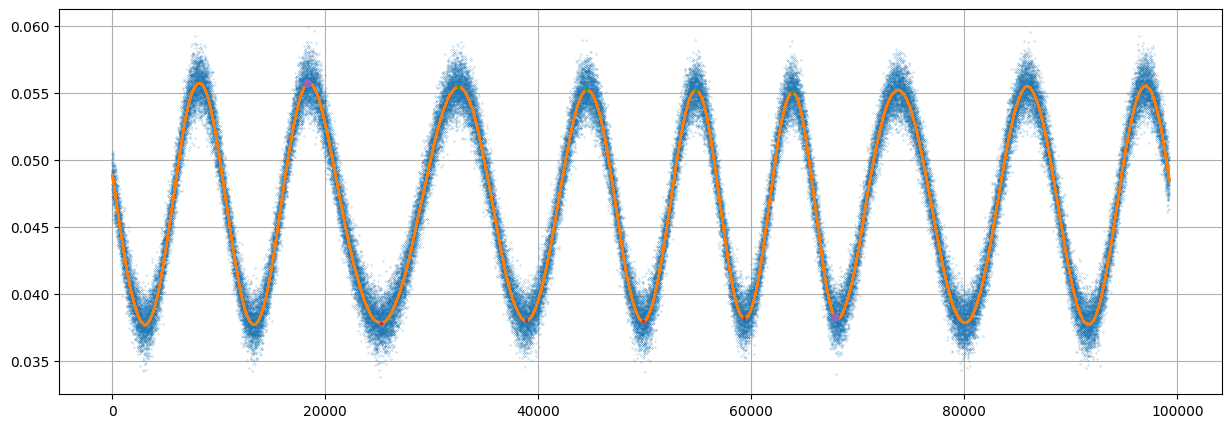

In [179]:
# example
dir_mmt = r"C:\Users\QMPL\Documents\LeoKon\PicoScope"
f_name = "251024_l=800um_wl=1534-79.mat"
fp = os.path.join(dir_mmt, f_name)

ps_data = AnalysePSData(fp)
ps_data.filter_lowpass(cutoff_pc=0.01, order=6)
ps_data.filter_savgol(polyorder=2)
ps_data.get_idx_local_extrema(rel_height=0.5, in_window=True, buffer=500)

d_frmax, d_frmin = ps_data.get_fringe_distances()

fig = plt.figure(figsize=(15, 5))
plt.plot(ps_data.t, ps_data.signal_raw, ".", ms=0.3)
plt.plot(ps_data.t, ps_data.signal_savgol, ".", ms=0.3)
plt.plot(ps_data.t[ps_data.idx_max], ps_data.signal_savgol[ps_data.idx_max], ".", ms=3.)
plt.plot(ps_data.t[ps_data.idx_min], ps_data.signal_savgol[ps_data.idx_min], ".", ms=3.)
plt.plot(ps_data.t[ps_data.idx_wn], ps_data.signal_savgol[ps_data.idx_wn], ".", ms=10.)
plt.grid()

print(d_frmax, d_frmin)

Text(0.5, 0, 'Fringe number')

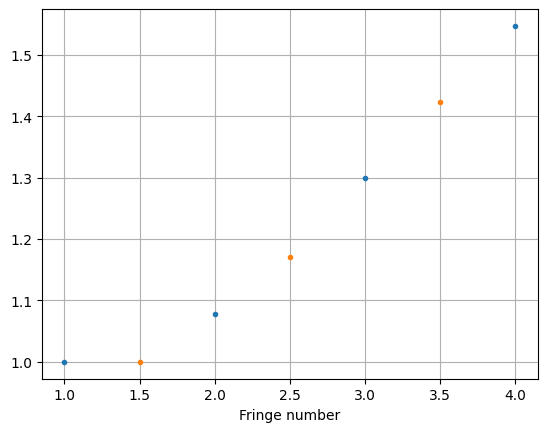

In [248]:
timestamps = time_fbox[idx_localmax]

timestamps_lower = time_fbox[idx_localmin]
timestamps_valid = timestamps_lower[(1, 2, 3, 4), ]

periods = np.diff(timestamps, axis=0)
periods = periods / np.amin(periods)

periods_lower = np.diff(timestamps_valid, axis=0)
periods_lower = periods_lower / np.amin(periods_lower)


plt.plot([1, 2, 3, 4], periods[::-1], ".")
plt.plot([1.5, 2.5, 3.5], periods_lower[::-1], ".")
plt.grid()
plt.xlabel("Fringe number")